# Data Segmentation

- Preprocessing

In [ ]:
# Loading and cleaning
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
sys.path.append(r'C:\Frank\UoT 2024-2025\MIE8888 Project\M18\RUIWU') 
from helper_functions import * # Import Ruiwu's helper functions for data cleaning, slicing and aggregating

full_dataset = r"C:\Frank\UoT 2024-2025\MIE8888 Project\full_dataset_2.11.csv"
df = pd.read_csv(full_dataset, encoding="Windows-1252")

# Define trash columns
trash_columns = ['id_x_x','sikka_sub_task_operation_x_x','office_x_x','guarantor_x','patient','description','visible_to_patient','primary_insurance_estimate','secondary_insurance_estimate','plan_sr_no','insurance_payment','approved','from_pms_x_x','id_y_x','from_pms_y_x','sikka_sub_task_y_x','sikka_sub_task_operation_y_x','uuid','guarantor_y','office_y_x','fullname','first_name','last_name','address','phone','zip_code','practice','primary_insurance_company_id','profile_picture','date_joined','zip_code_flag','address_comp','final_zip_code','id_x_y','from_pms_x_y','office_x_y','treatment','id_y_y','from_pms_y_y','sikka_sub_task_y_y','sikka_sub_task_operation_y_y','office_y_y','procedure_code_x','procedure_code_description','patient_friendly_description','treatment_id','price','fetched_zip_code_flag','zip_code_verified','fetched_zip_code', 'entry_date', 'tooth_from']

df = drop_high_nan_columns(df) 
df = df.drop(columns = trash_columns) # Drop trash cols
df = merge_columns_with_priority(df,'health_category','procedure_code_category','treatment_category') # merge to get treatment_category with pattern from two category groups
df = df.dropna() # Drop the remaining NA
df, df_dict = object_processing(df) # Project columns dtype = object; For columns containing datetime, convert it to pd.datetime; For other object columns, encode them
df = days_cal_v2(df,'procedure_date','birth_date', 'procedure_age') # age group preparation (modify to int)
df = days_cal_v2(df,'last_visit','first_visit','visit_period')

# # Perform one-hot encoding on the "procedure_code_y" and "treatment_category"
df = one_hot_encode_procedure_and_treatment(df)
# df.to_csv(r'C:\Frank\UoT 2024-2025\MIE8888 Project\M18\output.csv', index=False)

C:\Users\frank\AppData\Local\Temp\ipykernel_6976\440484244.py:10: DtypeWarning: Columns (1,4,10,16,52,85,86,91) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(full_dataset, encoding="Windows-1252")
C:\Frank\UoT 2024-2025\MIE8888 Project\M18\RUIWU\helper_functions.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  temp_dt = pd.to_datetime(df[col], errors='raise')
C:\Frank\UoT 2024-2025\MIE8888 Project\M18\RUIWU\helper_functions.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  temp_dt = pd.to_datetime(df[col], errors='raise')
C:\Frank\UoT 2024-2025\MIE8888 Project\M18\RUIWU\helper_functions.py:40: UserWarning: Could not infer format, so each element will be pars

In [2]:
df_next = df.copy() # for next step use
df_next.tail()

,provider_x,amount,treatment_plan_status,procedure_date,patient_id,birth_date,city,state_y,first_visit,last_visit,...,treatment_category_12,treatment_category_13,treatment_category_14,treatment_category_15,treatment_category_16,treatment_category_17,treatment_category_18,treatment_category_19,treatment_category_20,treatment_category_21
354032,1,25.22,0,2007-07-11,7997,1999-04-07,15,0,2002-08-14,2023-08-23,...,False,False,False,False,False,False,False,False,False,False
354033,1,96.26,0,2007-07-11,7997,1999-04-07,15,0,2002-08-14,2023-08-23,...,False,False,False,False,False,False,False,False,False,False
354034,4,23.66,0,2007-07-11,3107,1960-11-21,0,0,1992-10-13,2024-09-27,...,False,False,False,False,False,False,False,False,False,False
354035,3,87.06,0,1996-12-12,2679,1976-06-05,0,0,1991-12-10,2013-05-14,...,False,False,False,False,False,False,False,False,False,False
354036,4,23.66,0,2007-07-11,8157,2000-04-25,0,0,2003-08-11,2019-12-05,...,False,False,False,False,False,False,False,False,False,False


## Divide patient-level treatment dataset into three groups (V1, V2, V3) based on the continuity and duration of their visit history
Definitions:
- First Visit Date: Start of treatment history
- Last Visit Date: End of treatment history
- Procedure Data: The date which procedure occurred
- Max Gap: Largest time gap between consecutive visits
- Duration: Total time span = Last Visit Date - First Visit Date

V1 (Very Consistent): Max gap between visits is less than 2 years (Doesn’t matter how long the total history is, as long as it's consistent)  
V2 (Inconsistent but Long History): Max gap is 2 years or more; Total duration is 7 years or more  
V3 (Inconsistent and Short History): Everything else

In [3]:
def classify_patient(group):
    procedure_dates = group.sort_values('procedure_date')['procedure_date']
    
    # Visit span in years
    span_years = (group['last_visit'].iloc[0] - group['first_visit'].iloc[0]).days / 365.0

    # Maximum time gap between consecutive visits
    gaps = procedure_dates.diff().dropna().dt.days / 365.0
    max_gap = gaps.max() if not gaps.empty else 0

    # Classification
    if span_years >= 1 and max_gap <= 2:
        return 'V1'
    elif span_years >= 7:
        return 'V2'
    else:
        return 'V3'

# Apply the classification
patient_versions = df_next.groupby('patient_id').apply(classify_patient).reset_index()
patient_versions.columns = ['patient_id', 'version']

# Merge version info back to full dataset (Treatment Based)
df_next = df_next.merge(patient_versions, on='patient_id')


C:\Users\frank\AppData\Local\Temp\ipykernel_6976\1109234042.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  patient_versions = df_next.groupby('patient_id').apply(classify_patient).reset_index()


In [17]:
patient_versions

,patient_id,version
0,1,V2
1,2,V2
2,3,V1
3,4,V2
4,5,V2
...,...,...
10253,13579,V3
10254,13580,V3
10255,13583,V3
10256,13584,V3


In [4]:
df_v1 = df_next[df_next['version'] == 'V1']
df_v2 = df_next[df_next['version'] == 'V2']
df_v3 = df_next[df_next['version'] == 'V3']

In [7]:
# df_v1.to_csv(r'C:\Frank\UoT 2024-2025\MIE8888 Project\M19\df_v1.csv', index=False)
# df_v2.to_csv(r'C:\Frank\UoT 2024-2025\MIE8888 Project\M19\df_v2.csv', index=False)
# df_v3.to_csv(r'C:\Frank\UoT 2024-2025\MIE8888 Project\M19\df_v3.csv', index=False)

- Progress Check

In [26]:
df_v1

,provider_x,amount,treatment_plan_status,procedure_date,patient_id,birth_date,city,state_y,first_visit,last_visit,...,treatment_category_13,treatment_category_14,treatment_category_15,treatment_category_16,treatment_category_17,treatment_category_18,treatment_category_19,treatment_category_20,treatment_category_21,version
9,1,544.16,0,2007-07-10,6239,1968-07-15,3,0,1998-04-14,2022-07-13,...,False,False,False,False,False,False,False,False,False,V1
14,2,30.00,0,2007-07-10,5913,1935-10-26,2,0,1997-08-12,2015-06-22,...,False,False,False,False,False,False,False,False,False,V1
18,2,99.81,0,2001-10-22,5913,1935-10-26,2,0,1997-08-12,2015-06-22,...,False,False,False,False,False,False,False,False,False,V1
21,1,59.11,0,2007-07-10,9456,2003-10-15,5,0,2007-07-10,2024-10-19,...,False,False,False,False,False,False,False,False,False,V1
22,4,96.26,0,2007-07-09,5492,1960-08-11,0,0,1996-11-12,2024-07-18,...,False,False,False,False,False,False,False,False,False,V1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332504,4,33.46,0,2007-07-11,3107,1960-11-21,0,0,1992-10-13,2024-09-27,...,False,False,False,False,False,False,False,False,False,V1
332505,0,96.81,0,2000-09-30,8378,1999-07-27,0,0,2003-09-23,2009-12-08,...,False,False,False,False,False,False,False,False,False,V1
332506,0,96.81,0,2000-09-30,1165,1941-07-08,1,0,1989-07-25,2024-12-19,...,False,False,False,False,False,False,False,False,False,V1
332509,4,96.26,0,2007-07-11,3107,1960-11-21,0,0,1992-10-13,2024-09-27,...,False,False,False,False,False,False,False,False,False,V1


In [ ]:
# V1 sample
patient_df = df_next[df_next['patient_id'] == 6239].sort_values('procedure_date')
print(patient_df[['procedure_date', 'first_visit', 'last_visit']])

span_years = (patient_df['last_visit'].iloc[0] - patient_df['first_visit'].iloc[0]).days / 365.0
gaps = patient_df['procedure_date'].sort_values().diff().dropna().dt.days / 365.0
max_gap = gaps.max()
print(f"Visit span (years): {span_years:.2f}")
print(f"Max gap between visits (years): {max_gap:.2f}")


      procedure_date first_visit last_visit
19301     1998-04-14  1998-04-14 2022-07-13
19302     1998-04-14  1998-04-14 2022-07-13
19303     1998-04-14  1998-04-14 2022-07-13
19304     1998-04-14  1998-04-14 2022-07-13
19305     1998-04-14  1998-04-14 2022-07-13
...              ...         ...        ...
60623     2021-11-17  1998-04-14 2022-07-13
59936     2022-07-13  1998-04-14 2022-07-13
59935     2022-07-13  1998-04-14 2022-07-13
59934     2022-07-13  1998-04-14 2022-07-13
59943     2022-07-13  1998-04-14 2022-07-13

[110 rows x 3 columns]
Visit span (years): 24.26
Max gap between visits (years): 1.55


In [27]:
df_v2

,provider_x,amount,treatment_plan_status,procedure_date,patient_id,birth_date,city,state_y,first_visit,last_visit,...,treatment_category_13,treatment_category_14,treatment_category_15,treatment_category_16,treatment_category_17,treatment_category_18,treatment_category_19,treatment_category_20,treatment_category_21,version
0,0,25.22,0,2004-04-19,6672,1991-11-26,0,0,1999-04-14,2020-02-20,...,False,False,False,False,False,False,False,False,False,V2
1,0,32.96,0,2004-04-19,6672,1991-11-26,0,0,1999-04-14,2020-02-20,...,False,False,False,False,False,False,False,False,False,V2
2,0,47.09,0,2004-04-19,6672,1991-11-26,0,0,1999-04-14,2020-02-20,...,False,False,False,False,False,False,False,False,False,V2
3,0,21.36,0,2004-04-19,6672,1991-11-26,0,0,1999-04-14,2020-02-20,...,False,False,False,False,False,False,False,False,False,V2
4,1,57.10,0,2007-07-11,2479,1939-01-21,1,0,1991-08-08,2019-04-17,...,False,False,False,False,False,False,False,False,False,V2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332508,1,107.18,0,2007-07-11,1422,1947-02-05,0,0,1989-07-08,2024-12-23,...,False,False,False,False,False,False,False,False,False,V2
332510,1,25.22,0,2007-07-11,7997,1999-04-07,15,0,2002-08-14,2023-08-23,...,False,False,False,False,False,False,False,False,False,V2
332511,1,96.26,0,2007-07-11,7997,1999-04-07,15,0,2002-08-14,2023-08-23,...,False,False,False,False,False,False,False,False,False,V2
332513,3,87.06,0,1996-12-12,2679,1976-06-05,0,0,1991-12-10,2013-05-14,...,False,False,False,False,False,False,False,False,False,V2


In [28]:
# V2 sample
patient_df = df_next[df_next['patient_id'] == 6672].sort_values('procedure_date')
print(patient_df[['procedure_date', 'first_visit', 'last_visit']])

span_years = (patient_df['last_visit'].iloc[0] - patient_df['first_visit'].iloc[0]).days / 365.0
gaps = patient_df['procedure_date'].sort_values().diff().dropna().dt.days / 365.0
max_gap = gaps.max()
print(f"Visit span (years): {span_years:.2f}")
print(f"Max gap between visits (years): {max_gap:.2f}")


      procedure_date first_visit last_visit
17426     1999-04-14  1999-04-14 2020-02-20
17425     1999-04-14  1999-04-14 2020-02-20
17427     1999-04-14  1999-04-14 2020-02-20
17428     1999-04-14  1999-04-14 2020-02-20
17365     1999-04-26  1999-04-14 2020-02-20
...              ...         ...        ...
63071     2019-07-22  1999-04-14 2020-02-20
62329     2020-01-27  1999-04-14 2020-02-20
62331     2020-01-27  1999-04-14 2020-02-20
62237     2020-02-20  1999-04-14 2020-02-20
62236     2020-02-20  1999-04-14 2020-02-20

[69 rows x 3 columns]
Visit span (years): 20.87
Max gap between visits (years): 3.98


In [29]:
df_v3

,provider_x,amount,treatment_plan_status,procedure_date,patient_id,birth_date,city,state_y,first_visit,last_visit,...,treatment_category_13,treatment_category_14,treatment_category_15,treatment_category_16,treatment_category_17,treatment_category_18,treatment_category_19,treatment_category_20,treatment_category_21,version
89,4,33.00,0,2007-06-26,9467,1972-02-06,14,0,2007-01-25,2008-07-16,...,False,False,False,False,False,False,False,False,False,V3
90,4,144.00,0,2007-01-29,9467,1972-02-06,14,0,2007-01-25,2008-07-16,...,False,False,False,False,False,False,False,False,False,V3
125,3,35.00,0,2007-06-18,9593,1968-02-12,17,0,2007-06-12,2007-06-25,...,False,False,False,False,False,False,False,False,False,V3
129,3,145.00,0,2007-06-18,9593,1968-02-12,17,0,2007-06-12,2007-06-25,...,False,False,False,False,False,False,False,False,False,V3
156,4,45.00,0,2007-06-12,9593,1968-02-12,17,0,2007-06-12,2007-06-25,...,False,False,False,False,False,False,False,False,False,V3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332474,4,118.23,0,2007-07-17,9579,1980-06-14,0,0,2007-07-17,2008-04-15,...,False,False,False,False,False,False,False,False,False,V3
332477,1,115.96,0,2007-07-16,3365,1956-04-07,0,0,1993-03-10,1993-03-10,...,False,False,False,False,False,False,False,False,False,V3
332478,1,115.96,0,2007-07-16,9595,1956-04-07,0,0,2007-06-12,2007-07-16,...,False,False,False,False,False,False,False,False,False,V3
332484,1,285.51,0,2007-07-16,3365,1956-04-07,0,0,1993-03-10,1993-03-10,...,False,False,False,False,False,False,False,False,False,V3


In [30]:
# V3 sample
patient_df = df_next[df_next['patient_id'] == 9467].sort_values('procedure_date')
print(patient_df[['procedure_date', 'first_visit', 'last_visit']])

span_years = (patient_df['last_visit'].iloc[0] - patient_df['first_visit'].iloc[0]).days / 365.0
gaps = patient_df['procedure_date'].sort_values().diff().dropna().dt.days / 365.0
max_gap = gaps.max()
print(f"Visit span (years): {span_years:.2f}")
print(f"Max gap between visits (years): {max_gap:.2f}")

      procedure_date first_visit last_visit
877       2007-01-25  2007-01-25 2008-07-16
878       2007-01-25  2007-01-25 2008-07-16
879       2007-01-25  2007-01-25 2008-07-16
90        2007-01-29  2007-01-25 2008-07-16
36554     2007-01-29  2007-01-25 2008-07-16
83792     2007-01-29  2007-01-25 2008-07-16
83791     2007-01-29  2007-01-25 2008-07-16
676       2007-02-28  2007-01-25 2008-07-16
4628      2007-02-28  2007-01-25 2008-07-16
89        2007-06-26  2007-01-25 2008-07-16
84444     2007-10-30  2007-01-25 2008-07-16
84442     2007-10-30  2007-01-25 2008-07-16
83793     2008-03-04  2007-01-25 2008-07-16
83794     2008-03-04  2007-01-25 2008-07-16
83801     2008-03-04  2007-01-25 2008-07-16
83508     2008-04-28  2007-01-25 2008-07-16
83509     2008-04-28  2007-01-25 2008-07-16
83205     2008-06-12  2007-01-25 2008-07-16
83213     2008-06-12  2007-01-25 2008-07-16
46743     2017-02-07  2007-01-25 2008-07-16
46742     2017-02-07  2007-01-25 2008-07-16
46744     2017-02-07  2007-01-25

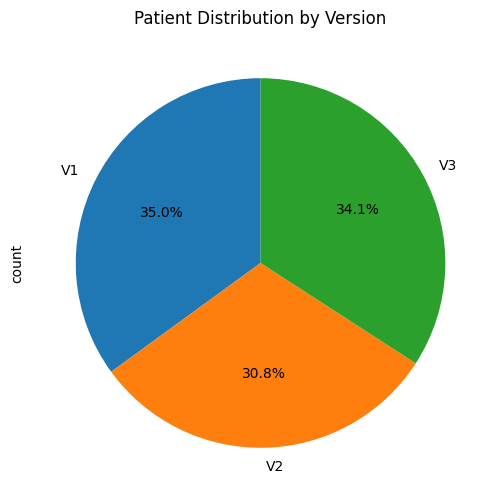

In [34]:
# Same version_counts as before
plt.figure(figsize=(6, 6))
version_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title("Patient Distribution by Version")
plt.show()


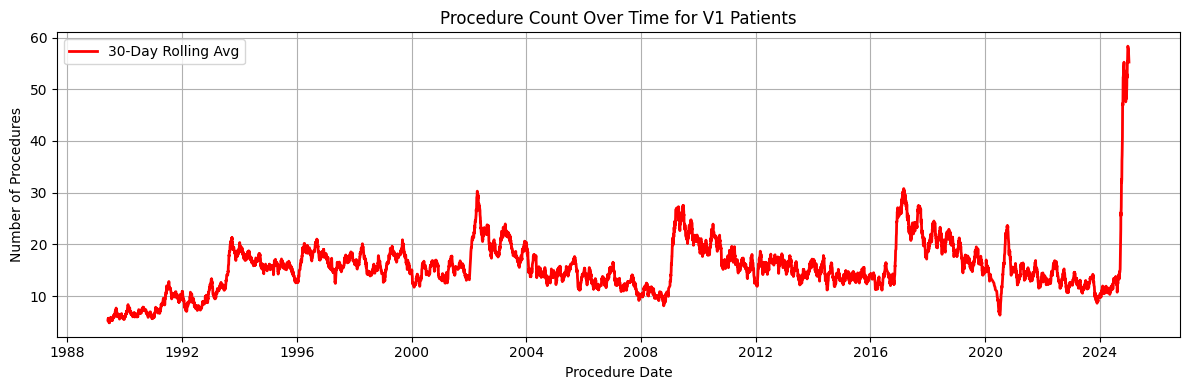

In [44]:
# Filter for V1 patients
df_v1 = df_next[df_next['version'] == 'V1']

# Count procedures per day
v1_visit_counts = df_v1.groupby('procedure_date').size()

# 30-day rolling average for smoothing
v1_smoothed = v1_visit_counts.rolling(window=30).mean()

# Plot both raw and smoothed data
plt.figure(figsize=(12, 4))
# plt.plot(v1_visit_counts.index, v1_visit_counts.values, alpha=0.3, label='Daily Count', linestyle='-', marker='o')
plt.plot(v1_smoothed.index, v1_smoothed.values, color='red', label='30-Day Rolling Avg', linewidth=2)
plt.title("Procedure Count Over Time for V1 Patients")
plt.xlabel("Procedure Date")
plt.ylabel("Number of Procedures")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


V1 Patients – Very Consistent: Steady and reliable activity from 1990 to 2022. Strong and recent surge in 2023–2024.
Which implies: V1 patients are excellent for predictive modeling; Use them to train baseline models: they have more complete histories and stable behavior.

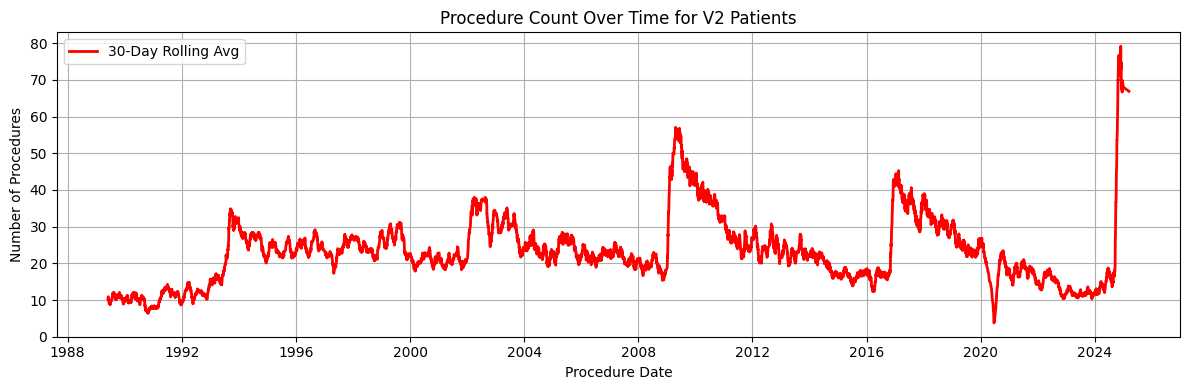

In [47]:
# Filter for V2 patients
df_v2 = df_next[df_next['version'] == 'V2']

# Count procedures per day
v2_visit_counts = df_v2.groupby('procedure_date').size()

# 30-day rolling average for smoothing
v2_smoothed = v2_visit_counts.rolling(window=30).mean()

# Plot both raw and smoothed data
plt.figure(figsize=(12, 4))
# plt.plot(v2_visit_counts.index, v2_visit_counts.values, alpha=0.3, label='Daily Count', linestyle='-', marker='o')
plt.plot(v2_smoothed.index, v2_smoothed.values, color='red', label='30-Day Rolling Avg', linewidth=2)
plt.title("Procedure Count Over Time for V2 Patients")
plt.xlabel("Procedure Date")
plt.ylabel("Number of Procedures")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


V2 starts similarly to V1 but shows more fluctuations and sharp peaks. Activity is long-lasting but irregular.

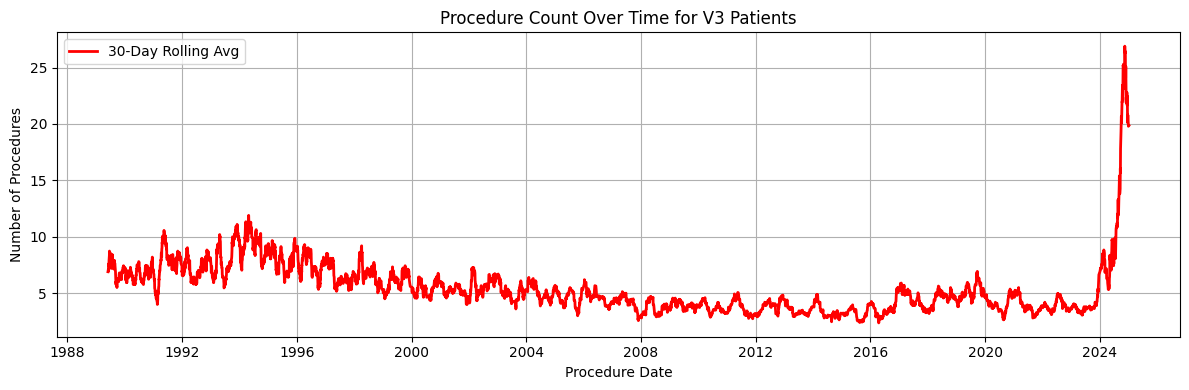

In [48]:
# Filter for V3 patients
df_v3 = df_next[df_next['version'] == 'V3']

# Count procedures per day
v3_visit_counts = df_v3.groupby('procedure_date').size()

# 30-day rolling average for smoothing
v3_smoothed = v3_visit_counts.rolling(window=30).mean()

# Plot both raw and smoothed data
plt.figure(figsize=(12, 4))
# plt.plot(v3_visit_counts.index, v3_visit_counts.values, alpha=0.3, label='Daily Count', linestyle='-', marker='o')
plt.plot(v3_smoothed.index, v3_smoothed.values, color='red', label='30-Day Rolling Avg', linewidth=2)
plt.title("Procedure Count Over Time for V3 Patients")
plt.xlabel("Procedure Date")
plt.ylabel("Number of Procedures")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


V3 has lower and steadier activity from 1990–2015, but very large recent spike in 2023–2024. This suggests many new or trial patients entering the system. In this case, V3 may not be used for prediction models, but these data are also valuable.

## Age and category (v1, v2, v3)

C:\Users\frank\AppData\Local\Temp\ipykernel_840\691378553.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_distribution = df_next.groupby(['version', 'age_group']).size().unstack().fillna(0)


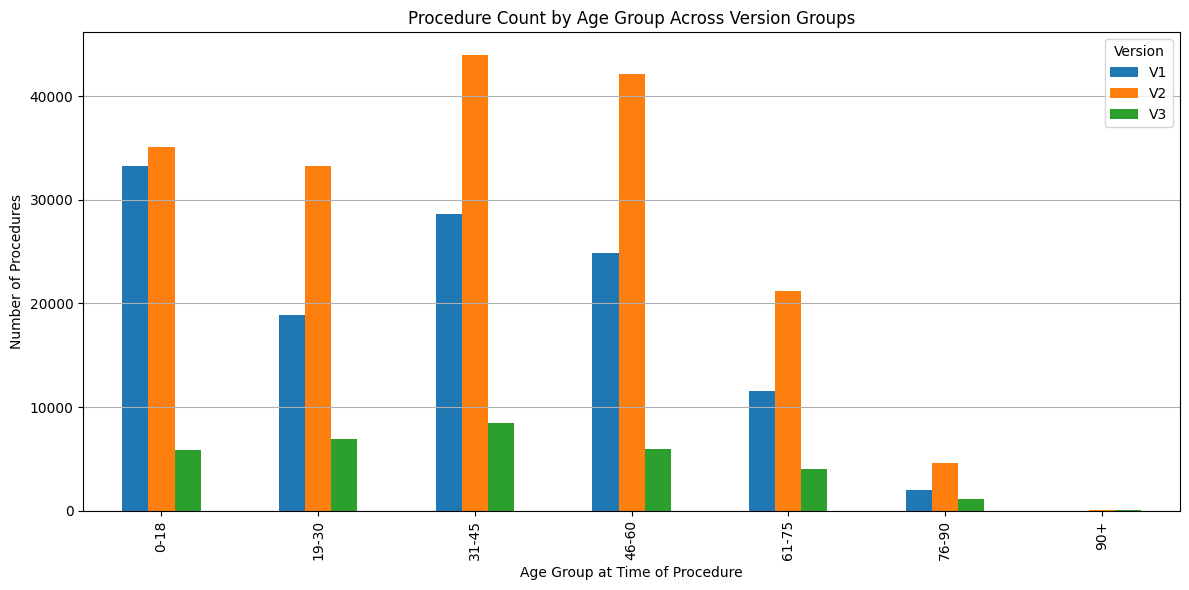

In [ ]:
# Calculate age at time of each procedure
df_next['age_at_procedure'] = (df_next['procedure_date'] - df_next['birth_date']).dt.days // 365

# Bucket into age groups
df_next['age_group'] = pd.cut(
    df_next['age_at_procedure'],
    bins=[0, 18, 30, 45, 60, 75, 90, 120],
    labels=['0-18', '19-30', '31-45', '46-60', '61-75', '76-90', '90+'])

# Count procedures per age group and version
age_distribution = df_next.groupby(['version', 'age_group']).size().unstack().fillna(0)

# Plot
age_distribution.T.plot(kind='bar', figsize=(12, 6))
plt.title("Procedure Count by Age Group Across Version Groups")
plt.xlabel("Age Group at Time of Procedure")
plt.ylabel("Number of Procedures")
plt.grid(axis='y')
plt.legend(title='Version')
plt.tight_layout()
plt.show()

- V1 patients distributed across all age groups, kids and middle-aged adults are highly consistent. V1 patients aren’t concentrated in only one demographic.

- V2 indicates that many patients maintain a long relationship with the clinic but have infrequent or irregular visits These may be patients who visit only for serious treatment or delay regular checkups

- V3 has much lower overall volume. Stands for temporary patients.